In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import griddata

import xarray as xr
import rioxarray as rxr
from pyproj import Proj, Transformer, CRS

In [2]:
## LOAD GRID AND GET COORDINATE LOCATIONS
grid1km = rxr.open_rasterio('grid_1km_v01.1.tif',
                                 masked=True)

grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)

crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)

grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)

In [3]:
# Data collection area
# Currently bounded by:
# Lat 42° S, 18° N
# Long 6° E, 80° E

In [4]:
# List of variables: PP, SPM, no3
variable = 'thetao'
download = False

if download:
    if variable == 'PP':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082-TDS \
            --product-id dataset-oc-glo-bio-multi-l4-pp_4km_monthly-rep \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable PP \
            --out-name CMEMS_PP.nc --user bqueste1 --pwd @nrIm10liv@
    if variable == 'SPM':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id OCEANCOLOUR_GLO_OPTICS_L4_REP_OBSERVATIONS_009_081-TDS \
            --product-id dataset-oc-glo-opt-multi-l4-spm_4km_monthly-rep-v02 \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable SPM \
            --out-name CMEMS_SPM.nc --user bqueste1 --pwd @nrIm10liv@
    if variable == 'ZSD':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id OCEANCOLOUR_GLO_OPTICS_L4_REP_OBSERVATIONS_009_081-TDS \
            --product-id dataset-oc-glo-opt-multi-l4-zsd_4km_monthly-rep-v02 \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable ZSD \
            --out-name CMEMS_ZSD.nc --user bqueste1 --pwd @nrIm10liv@
    if variable == 'no3':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id GLOBAL_REANALYSIS_BIO_001_029-TDS \
            --product-id global-reanalysis-bio-001-029-monthly \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --depth-min 0 --depth-max 50 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable no3 \
            --out-name CMEMS_no3.nc --user bqueste1 --pwd @nrIm10liv@
    if variable == 'thetao':
        ! python -m motuclient \
            --motu https://my.cmems-du.eu/motu-web/Motu \
            --service-id GLOBAL_REANALYSIS_PHY_001_030-TDS \
            --product-id global-reanalysis-phy-001-030-monthly \
            --longitude-min 5.5 --longitude-max 80.5 --latitude-min -42.5 --latitude-max 18.56 \
            --depth-min 0 --depth-max 10 \
            --date-min "2015-01-01 00:00:00" --date-max "2019-12-01 00:00:00" \
            --variable thetao \
            --out-name CMEMS_thetao.nc --user bqueste1 --pwd @nrIm10liv@

In [5]:
## LOAD UP CMEMS DATA FILE
data = xr.open_dataset('CMEMS_'+variable+'.nc')
data

<xarray.Dataset>
Dimensions:    (depth: 8, latitude: 734, longitude: 901, time: 59)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078 6.441 7.93 9.573
  * latitude   (latitude) float32 -42.5 -42.42 -42.33 ... 18.42 18.5 18.58
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2019-11-16
  * longitude  (longitude) float32 5.5 5.583 5.667 5.75 ... 80.33 80.42 80.5
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [6]:
if 'depth' in data.dims:
    data = data.mean(dim='depth')

In [7]:
# Average months together first, then by season, then by year to limit impact of reduced data at certain times of year-
month_length = data.time.dt.days_in_month

# Calculate the weights by grouping by 'time.month'.
weights = month_length.groupby('time.month') / month_length.groupby('time.month').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.month').sum().values, np.ones(12))

# Calculate the weighted average
clim = (data * weights).groupby('time.month').sum(dim='time')

In [8]:
# Now do climatological average
out = clim.mean(dim='month')

In [9]:
if 'lon' in data.dims:
    lons, lats = np.meshgrid(out.lon.values,out.lat.values) 
    valid = np.isfinite(out[variable].values.flatten())
if 'longitude' in data.dims:
    lons, lats = np.meshgrid(out.longitude.values,out.latitude.values) 
    valid = np.isfinite(out[variable].values.flatten())

In [10]:
tropicBoundary = True
if (variable == 'thetao') and tropicBoundary:
    out[variable] = out[variable]-25
    out[variable] = out[variable].where(out[variable] > 0, 0)
    out[variable] = out[variable]/2.5
    out[variable] = out[variable].where(out[variable] < 1, 1)
    out[variable] = out[variable].where(lats < 0, 1)
    out = out.rename({variable : 'tropicalLimit'})
    variable='tropicalLimit'

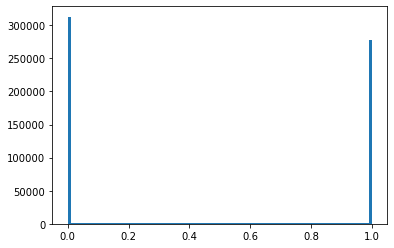

In [11]:
_ = plt.hist(out[variable].values.flatten(),100)

In [12]:
raster = griddata((lons.flatten()[valid], lats.flatten()[valid]), out[variable].values.flatten()[valid] , (grid_lon, grid_lat))

In [13]:
grid1km.values = grid1km.values*raster

In [14]:
grid1km

<xarray.DataArray (band: 1, y: 5961, x: 7633)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -4.405e+05 -4.395e+05 ... 7.190e+06 7.192e+06
  * y            (y) float64 1.79e+06 1.788e+06 ... -4.17e+06 -4.170e+06
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:  1
    STATISTICS_MEAN:     1.#SNAN
    STATISTICS_MINIMUM:  1
    STATISTICS_STDDEV:   1.#SNAN
    scale_factor:        1.0
    add_offset:          0.0

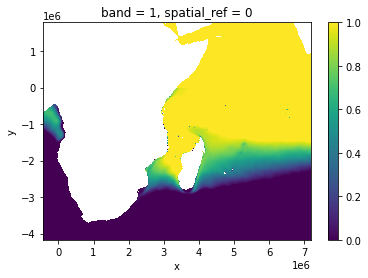

In [15]:
grid1km.plot()

In [16]:
grid1km.rio.to_raster("grid_1km_"+variable+"_byq.tif")

In [17]:
data

<xarray.Dataset>
Dimensions:    (latitude: 734, longitude: 901, time: 59)
Coordinates:
  * latitude   (latitude) float32 -42.5 -42.42 -42.33 ... 18.42 18.5 18.58
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2019-11-16
  * longitude  (longitude) float32 5.5 5.583 5.667 5.75 ... 80.33 80.42 80.5
Data variables:
    thetao     (time, latitude, longitude) float32 10.67 10.62 10.55 ... nan nan